# Live Coding
## Week 7 Textual Data

__Outline__
>T1 - Libraries & setup  
T2 - Loading data and removing na   
T3 - Convert to spatial data and plot   
T4 - Preview textual data  
T5 - Using regular expressions  
T6 - Text cleaning  
T7 - Lemmitasation vs Stemming  
T8 - Normalise (apply method)  
T9 - Extract features  

In [1]:
# Libraries and modules
import os
import pandas as pd
import geopandas as gpd
import re # regular expressions (sequence of characters that specifies a search pattern)
import string # module contains some constants, utility function, and classes for string manipulation
import unicodedata # provides access to the Unicode Character Database (UCD) which defines character properties for all Unicode characters
from bs4 import BeautifulSoup # a Python library for pulling data out of HTML and XML files

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [2]:
# a machine learning library. It features various classification, regression and clustering algorithms
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
import nltk # libraries and programs for symbolic and statistical natural language processing for English
import spacy # library for advanced natural language processing
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# This next is just a small utility function that allows us to output Markdown (like this cell) instead of plain text:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head is not '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True) # level five header inside the Code cell
    else:
        display_markdown(f">{body}\n", raw=True)

<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_94/4250598317.py:5: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if head is not '':


In [5]:
# load a subset of the columns--we don't need all 70+ fields, just a few that might be useful for textual analysis
cols = ['id','listing_url','name','price','description','host_id','host_about','host_listings_count',
        'latitude','longitude','property_type','room_type','accommodates',
        'bathrooms','bathrooms_text','bedrooms','beds','amenities',]

url = 'https://github.com/jreades/i2p/blob/master/data/src/2020-08-24-listings.csv.gz?raw=true' 

df = pd.read_csv(url, usecols=cols, compression='gzip', low_memory=False)
df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)

/tmp/ipykernel_94/2812393273.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)


In [6]:
# remove lat/long na and records outside study area 
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
print(df.shape)

(74184, 18)


In [7]:
# remove na values from text fields. Is this ok for you? Any problems with this?
# null value will be a problem
# description, host_about, amenities

~(df.description.isna()) # tilde to negate expression

0        True
1        True
2        True
3        True
4        True
         ... 
74183    True
74184    True
74185    True
74186    True
74187    True
Name: description, Length: 74184, dtype: bool

In [8]:
# preview what this is doing
df[(df.description.isna()) | (df.host_about.isna()) | (df.amenities.isna())][['description', 'host_about', 'amenities']]

,description,host_about,amenities
11,"<b>The space</b><br />Comfortable, large doubl...",NaN,[]
26,Munster Village is a colourful collection of s...,NaN,"[""Laptop-friendly workspace"", ""Paid parking on..."
45,"<b>The space</b><br />Home away from home, Bes...",NaN,[]
46,<b>The space</b><br />WELCOME TO BEST INN HOTE...,NaN,"[""Wifi"", ""Breakfast"", ""Smoke alarm"", ""Carbon m..."
55,"<b>The space</b><br />Best Location, just 2 mi...",NaN,"[""Wifi"", ""Breakfast"", ""Smoke alarm"", ""Dryer"", ..."
...,...,...,...
74182,Clean and friendly house with garden and kitch...,NaN,"[""Laptop-friendly workspace"", ""Wifi"", ""Iron"", ..."
74183,5 Minutes walk to Surrey Quays overground stat...,NaN,"[""Kitchen"", ""Smoke alarm"", ""Carbon monoxide al..."
74185,"Charming bright airy garden flat, a short dist...",NaN,"[""Private entrance"", ""Kitchen"", ""Smoke alarm"",..."
74186,Its clean house friendly flat mates special fo...,NaN,"[""Wifi"", ""Private entrance"", ""Kitchen"", ""Smoke..."


In [9]:
# this drops 30% of the data!
df.drop(index=df[(df.description.isna()) | (df.host_about.isna()) | (df.amenities.isna())].index, inplace=True)
print(df.shape)

(41194, 18)


In [10]:
# Load spatial data for context
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [11]:
# Convert to geopandas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

(175000.0, 190000.0)

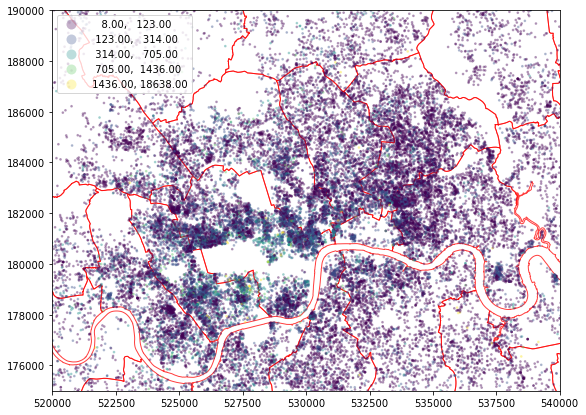

In [12]:
f,ax=plt.subplots(figsize=(10,7))
boros.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
gdf.plot(ax=ax, markersize=3, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', alpha=0.3, legend=True,)
ax.set_xlim([520000, 540000])
ax.set_ylim([175000, 190000])

In [13]:
# preview textual data
# change the amount of preview text provided using the pandas options
print(pd.options.display.max_colwidth) # What's this currently set to? (number of characthers)
pd.options.display.max_colwidth=150    # What do we want to set it to?

50


> In a full text-mining application I would spend a lot more time on this stage: sampling, looking at descriptions in full, performing my analysis (the rest of the steps) and then coming back with a deeper understanding of the data to make further changes to the analysis. Data science is about iterations

In [14]:
# look at 'description' sample
# Technically, the `isna` ([~gdf.description.isna()]) is no longer needed, but I left it here for 
# illustrative purposes about how I went about researching what was in
# the data before filtering it out in the cell block up above
gdf[~gdf.description.isna()].description.sample(8, random_state=42)
# Look! Spatial data expressed as text!

37453    My appartement has independent kitchen and bathroom. It is close to Lewisham train station and DLR station. It’s only 3-minute walk to supermarket...
3518     Couples, Parent with kids, Friends. Very Central but Quiet & Green. <br />Hyde Park/Paddington 5 min walk. Nottinghill/Oxford St/Mayfair 15 min. <...
49228    Pick up and drop off available from any UK location by separate negotiation.<br /><br /><br />Stunning recently refurbished 2 double bedroom apart...
46299    Ground floor entire apartment close to Gidea Park Train Station ( 15 minutes to London Stratford, London Underground, Shopping and London (Olympic...
9725     5 mins away from Clapham Junction station, ready to take you to anywhere in London or the rest of the country. <br />The apartment is newly redeco...
70010    Contemporary apartments are bright and spacious with a stylish open plan kitchen and living area and ample natural light pouring in from floor to ...
950      Single bedroom overlooking garden and

In [15]:
gdf.host_about.sample(8, random_state=42)

37453                                                                                                                   I work in the higher education sector.
3518     We are family of artists, filmmakers, business consultants. I've been living across Europe and India for most of my adult life while the rest of m...
49228                            I'm a friendly outgoing person. Always happy to help and will do everything I can to ensure you have a pleasant stay with us.
46299                                                                                                                  Respectable and responsible tourist\r\n
9725     I live in Central London and am a Trichologist for the Fulham Scalp & Hair Clinic.\r\n\r\nI  absolutely love to travel and meet new people as well...
70010                                                                                                  Global Property firm, Professional apartments operator 
950      Music teacher living in North London.

In [16]:
gdf.amenities.sample(8, random_state=42)
# list or series?
# Encode categorical features as a one-hot numeric array.

37453    ["Private living room", "Elevator", "Hot water", "Gym", "Hair dryer", "Kitchen", "Essentials", "Heating", "Hangers", "Laptop-friendly workspace", ...
3518     ["Host greets you", "Paid parking off premises", "Elevator", "Refrigerator", "Children\u2019s books and toys", "Dryer", "Hangers", "Indoor firepla...
49228    ["Refrigerator", "Dryer", "Hangers", "Free parking on premises", "Bed linens", "Shower gel", "Iron", "Hot water", "Kitchen", "Smoke alarm", "First...
46299    ["Refrigerator", "Hangers", "TV", "Free parking on premises", "Indoor fireplace", "Iron", "Hot water", "Kitchen", "Smoke alarm", "Carbon monoxide ...
9725     ["Laptop-friendly workspace", "Wifi", "Iron", "Kitchen", "Smoke alarm", "First aid kit", "Carbon monoxide alarm", "Essentials", "Hangers", "TV", "...
70010    ["Cable TV", "Elevator", "Hot water", "Gym", "Microwave", "Patio or balcony", "Dishes and silverware", "Shampoo", "Smoke alarm", "Wifi", "Kitchen"...
950      ["Host greets you", "Refrigerator", "

In [17]:
# using regular expressions to find patterns
# faster than using the full NLP (Natural Language Processing) pipeline 
# luxury
gdf[gdf.description.str.contains(r'luxury', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)
gdf[gdf.description.str.contains(r'luxur(y|ious)', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)

/tmp/ipykernel_94/3872131490.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  gdf[gdf.description.str.contains(r'luxur(y|ious)', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)


70180    Located in a serene and upscale part of North-West London is this  Stylish and Luxuriously furnished three bedroom three bathroom semi-detached ho...
1598     Charming modern 2-Bedroom Rooftop Flat with Terrace, in trendy Bermondsey area in South East London near Tower Bridge. <br /><br />Flat is ideally...
21119    Welcome to my very Special, "Secretly Hidden Little Gem!" where you'll find East meets Western inspirations, with Tokyo and New York design Influe...
21236    Interesting and quirky one bedroom flat offering an excellent lived in space. Large open living room, kitchen, dining, double bedroom and bathroom...
24262    Modern 2 Bed & 2 Bath Riverside Apartment situated within the glorious town of Greenwich.<br /><br />A leisurely 6 min riverside walk to the Cutty...
36048    This stunning London vacation rental is surrounded by green spaces, cafes and restaurants. Nestled on Royal Crescent this home is an exceptional f...
69221    This listing is for a lovely private 

In [18]:
#help(re)

In [19]:
# Assign it to a new data frame called lux:
lux = gdf[gdf.description.str.contains(r'luxur(y|ious)', regex=True, flags=re.IGNORECASE)]
print(lux.shape)

/tmp/ipykernel_94/1055095419.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  lux = gdf[gdf.description.str.contains(r'luxur(y|ious)', regex=True, flags=re.IGNORECASE)]


(3203, 19)


(175000.0, 190000.0)

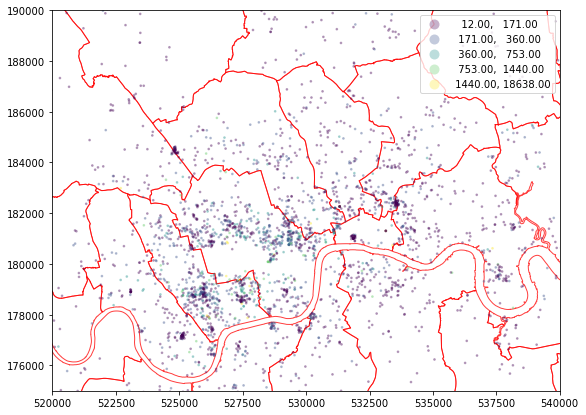

In [20]:
# plot
f,ax=plt.subplots(figsize=(10,7))
boros.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
lux.plot(ax=ax, markersize=3, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', alpha=0.3, legend=True,)
ax.set_xlim([520000, 540000])
ax.set_ylim([175000, 190000])

In [21]:
# typology
# pd.options.display.max_colwidth=150
# gdf[gdf.description.str.contains(r'(victorian|modern)', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)
gdf[gdf.description.str.contains(r'(family|children)', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)

/tmp/ipykernel_94/3505898623.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  gdf[gdf.description.str.contains(r'(family|children)', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)


64927    At Emerald Lets we provide beautiful, clean homes at a reasonable price. It is very important to us that our guests feel welcome and at home and t...
41358    A peaceful room overlooking the garden on the second floor of my Victorian home  in green and leafy Tulse Hill.  Its a short walk (maximum 10 minu...
44644    This is a flat people say “WHOA” when they see it. You will rarely find such a spacious and modern place with a free coffee from the DeLonghi coff...
67955    Luxurious Apartment “Woodship” Built in 2013, was my Garden,  I personally Project managed the build.  I am very proud to share my Apartment and i...
43334    Lovely 1 bedroom apartment with plenty of sunlight for 6 people. Located in the HEART of CAMDEN AREA, UNIQUE MODERN a few steps from CAMDEN TOWN a...
70170    A superbly presented two bedroom Victorian terraces cottage, with free PARKING. <br />The house extended to the rear. It is in a sought after road...
66920    This truly lovely apartment is locate

In [22]:
gdf[gdf.index == 67955]

,id,listing_url,name,description,host_id,host_about,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,geometry
67955,42510051.0,https://www.airbnb.com/rooms/42510051,Luxurious Modern Apartment “Woodship” Sleeps 5,"Luxurious Apartment “Woodship” Built in 2013, was my Garden, I personally Project managed the build. I am very proud to share my Apartment and i...",20732935.0,I was born in Bangladesh and grew up in the heart of London from the age of 10. I love traveling and It wasn't till I left London for my vacations...,2.0,51.59808,-0.10411,Entire guesthouse,Entire home/apt,5.0,NaN,1 bath,2.0,3.0,"[""Microwave"", ""Wifi"", ""Iron"", ""Lockbox"", ""Private entrance"", ""Kitchen"", ""First aid kit"", ""Smoke alarm"", ""Fire extinguisher"", ""Carbon monoxide alar...",118.0,POINT (531411.333 190506.379)


In [23]:
# pd.options.display.max_colwidth=None
gdf.loc[gdf.index == 67955, ['description']]

,description
67955,"Luxurious Apartment “Woodship” Built in 2013, was my Garden, I personally Project managed the build. I am very proud to share my Apartment and i..."


In [24]:
# check url to see listing on Airbnb website
gdf.loc[gdf.index == 67955, ['listing_url']]

,listing_url
67955,https://www.airbnb.com/rooms/42510051


In [25]:
pd.options.display.max_colwidth=150
# parks / green areas
gdf[gdf.description.str.contains(r'(park)', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)

/tmp/ipykernel_94/2646545370.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  gdf[gdf.description.str.contains(r'(park)', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)


73168    Garrett Mansions is a brand new modern residence with all the simple elegance and charm of classic London.<br />Designed by renowned architects Sq...
14369    Great spacious modern flat in the heart of Willesden Green. 3 minute walk from the Jubilee Line and close to supermarket and amenities. The flat i...
42671    I will respond to all enquiries/requests <br />Immediately <br />A spectacular 2 bedroom 2 bathroom apartment located Woolwich London with sensati...
1873     A quiet one double bedroom flat with garden available 15 mins from London City Airport and the Excel Exhibition centre. Located close to the Plais...
2345     Bright single room overlooking quiet garden and park.  Single bed, wardrobe, desk, shelving  and large chest of drawers.  Full access to kitchen a...
14755    Our recently modernised home is just off Northcote Road, near Wandsworth Common.  We love the area which is like a friendly village with cafes, re...
5213     1 bedroom flat in Bow Quarter, a beau

In [26]:
# online regex builder https://regex101.com/
gdf[gdf.description.str.contains(r'(parks?\b)', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)
# leafy, fields, square, etc.

/tmp/ipykernel_94/1681096791.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  gdf[gdf.description.str.contains(r'(parks?\b)', regex=True, flags=re.IGNORECASE)].description.sample(10, random_state=42)


23850    A cosy double in a gorgeous, loft-style apartment in Poets Corner, Brixton/ Herne Hill. The house is a short walk from Brixton centre or Herne hil...
53606    COVID-19 - following the centre for disease control and prevention (CDC) guidelines, the whole apartment has been sanitised with CLOROX, LYSOL. <b...
38727    This 2 bedroom top apartment is quiet, spacious, clean and bright,  located just 200 m away from the river Thames. Local shops (Sainsbury’s and As...
969      Large furnished Studio with cosy feel tucked away behind Upper Street in the gorgeous backstreets of Highbury & Islington/Angel, close to fantasti...
54856    This is a fabulous, quintessentially English 3 bed-apartment. With 3 comfortable bedrooms, and a fantastic spacious sitting room, flooded with lig...
57786    Fully equipped, beautiful apartment in a quiet area, only a few hundred yards from Putney Bridge and  the Thames, allowing for easy access to Rive...
7520     A light, spacious basement flat in lo

In [27]:
# Assign it to a new data frames:
chil = gdf[gdf.description.str.contains(r'(family|children)', regex=True, flags=re.IGNORECASE)]
print(chil.shape)
par = gdf[gdf.description.str.contains(r'(parks?\b)', regex=True, flags=re.IGNORECASE)]
print(par.shape)

/tmp/ipykernel_94/148821633.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  chil = gdf[gdf.description.str.contains(r'(family|children)', regex=True, flags=re.IGNORECASE)]


(6228, 19)


/tmp/ipykernel_94/148821633.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  par = gdf[gdf.description.str.contains(r'(parks?\b)', regex=True, flags=re.IGNORECASE)]


(11212, 19)


(175000.0, 190000.0)

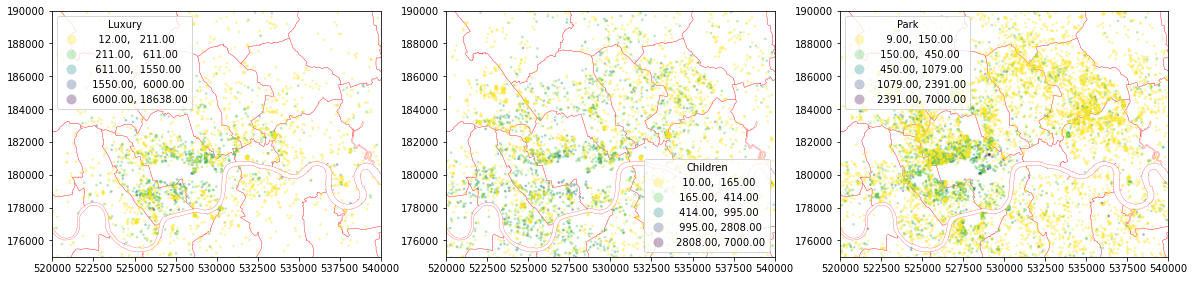

In [28]:
# plot all
f,ax=plt.subplots(1,3,figsize=(20,7))
boros.plot(ax=ax[0], edgecolor='red', facecolor='none', linewidth=0.3, alpha=0.75)
lux.plot(ax=ax[0], markersize=3, column='price', cmap='viridis_r', scheme='Fisher_Jenks_Sampled', alpha=0.3, legend=True, legend_kwds={'title': 'Luxury'})
boros.plot(ax=ax[1], edgecolor='red', facecolor='none', linewidth=0.3, alpha=0.75)
chil.plot(ax=ax[1], markersize=3, column='price', cmap='viridis_r', scheme='Fisher_Jenks_Sampled', alpha=0.3, legend=True, legend_kwds={'title': 'Children'})
boros.plot(ax=ax[2], edgecolor='red', facecolor='none', linewidth=0.3, alpha=0.75)
par.plot(ax=ax[2], markersize=3, column='price', cmap='viridis_r', scheme='Fisher_Jenks_Sampled', alpha=0.3, legend=True, legend_kwds={'title': 'Park'})
ax[0].set_xlim([520000, 540000])
ax[0].set_ylim([175000, 190000])
ax[1].set_xlim([520000, 540000])
ax[1].set_ylim([175000, 190000])
ax[2].set_xlim([520000, 540000])
ax[2].set_ylim([175000, 190000])

(175000.0, 190000.0)

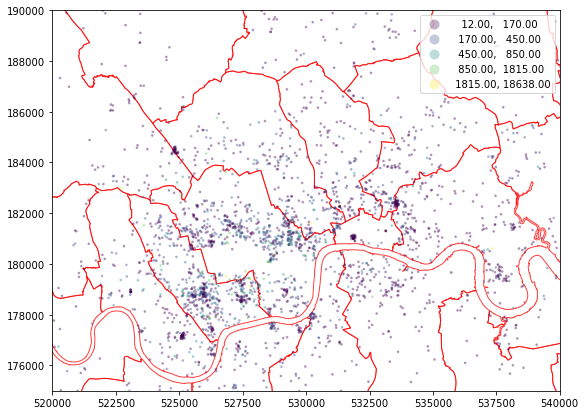

In [29]:
# plot
f,ax=plt.subplots(figsize=(20,7))
boros.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
lux.plot(ax=ax, markersize=3, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', alpha=0.3, legend=True)
ax.set_xlim([520000, 540000])
ax.set_ylim([175000, 190000])

In [30]:
# Does this match with my intuition
# Context matters! - situated knowledge - subject matter expertise limitations

In [31]:
# Text cleaning example
# clean and transform text
from urllib.request import Request, urlopen
url = 'https://www.ucl.ac.uk/bartlett/casa/about'
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

the_html = urlopen(req).read()

In [32]:
the_html[:2500]

b'<!DOCTYPE html>\n<!--[if IE 7]>\n<html lang="en" class="lt-ie9 lt-ie8 no-js"> <![endif]-->\n<!--[if IE 8]>\n<html lang="en" class="lt-ie9 no-js"> <![endif]-->\n<!--[if gt IE 8]><!-->\n<html lang="en" class="no-js"> <!--<![endif]-->\n<head>\n  <meta name="viewport" content="width=device-width, initial-scale=1.0"/>\n  <meta name="author" content="UCL"/>\n  <meta property="og:profile_id" content="uclofficial"/>\n  <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n<link rel="shortcut icon" href="https://www.ucl.ac.uk/bartlett/casa/sites/all/themes/indigo/favicon.ico" type="image/vnd.microsoft.icon" />\n<meta name="description" content="The Centre for Advanced Spatial Analysis (CASA) is an interdisciplinary research institute focusing on the science of cities within The Bartlett Faculty of the Built Environment at UCL." />\n<link rel="canonical" href="https://www.ucl.ac.uk/bartlett/casa/about-0" />\n<meta name="ucl:faculty" content="Bartlett" />\n<meta name="ucl:org_u

In [33]:
# turn to lowercase
lower = [x.lower() for x in the_html.decode("utf-8").split("\n") 
         if not re.match("^\s*$", x)] # identifying empty lines - only lines that contain sth get passed to lower (^ 'starts' and $ 'ends' with \s 'empty spaces', * 'matches previous token')

In [34]:
for l in lower[175:176]:
    as_markdown("Content", l)

##### Content

></div>casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation.<p>we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live.</p><p>based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities.</p><p>casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities.</p><h2 class="heading">our vision</h2><p>casa's focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base, drawing on cutting edge methods, and ideas in modeling, complexity, visualisation and computation.</p><p>our current mix of geographers, mathematicians, physicists, architects and computer scientists make casa a unique institute within ucl.</p><p>our vision is to be central to this new science, the science of smart cities, and relate it to city planning, policy and architecture in its widest sense.</p><p>the focus is on advancing the state of the art through research complemented by graduate study, teaching, consultancy and distance learning.</p><h2 class="heading">location</h2><p>the ucl centre for advanced spatial analysis is located at 90 tottenham court road, london, w1t 4tj. </p><p><a class="map-link map-link--0" href="//www.google.co.uk/maps/?z=15&amp;q=loc:51.521983,-0.1360091"><div class="map map--1">


In [35]:
lower[175:176]

['</div>casa\xa0was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation.<p>we seek\xa0to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live.</p><p>based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities.</p><p>casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities.</p><h2 class="heading">our vision</h2><p>casa\'s focus is to be at the forefront of what is one of th

In [36]:
# remove html tags
cleaned = []
for l in lower[175:176]:
    tmp = re.sub(r'(\/[A-Za-z]+\d?|[A-Za-z]+ \/)>','\\1> ', l) # character followed by digit - substitute with a space
    soup = BeautifulSoup(tmp, "html.parser")
    if not re.match(r'^\s*$',soup.get_text()): # again check if there are empty lines
        cleaned.append(soup.get_text())

In [37]:
for c in cleaned:
    as_markdown("Content", c)

##### Content

> casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation.we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live. based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities. casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities. our vision casa's focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base, drawing on cutting edge methods, and ideas in modeling, complexity, visualisation and computation. our current mix of geographers, mathematicians, physicists, architects and computer scientists make casa a unique institute within ucl. our vision is to be central to this new science, the science of smart cities, and relate it to city planning, policy and architecture in its widest sense. the focus is on advancing the state of the art through research complemented by graduate study, teaching, consultancy and distance learning. location the ucl centre for advanced spatial analysis is located at 90 tottenham court road, london, w1t 4tj.  


In [38]:
# remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;]+')
print(pattern)
punkt   = []
for c in cleaned:
    punkt.append(re.sub(pattern, ' ', c))

re.compile('[,\\.!\\-><=\\(\\)\\[\\]\\/&\\\'\\"’;]+')


In [39]:
for p in punkt:
    as_markdown("Content", p)

##### Content

> casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling  sensing the urban environment  visualisation and computation we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities  our vision is to play a central role in the science of smart cities – applying it to city planning  policy and architecture in the pursuit of making our cities better places to live  based in bloomsbury  london  casa is our living laboratory  as one of the world s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities  casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines  all with a common domain knowledge in cities  our vision casa s focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base  drawing on cutting edge methods  and ideas in modeling  complexity  visualisation and computation  our current mix of geographers  mathematicians  physicists  architects and computer scientists make casa a unique institute within ucl  our vision is to be central to this new science  the science of smart cities  and relate it to city planning  policy and architecture in its widest sense  the focus is on advancing the state of the art through research complemented by graduate study  teaching  consultancy and distance learning  location the ucl centre for advanced spatial analysis is located at 90 tottenham court road  london  w1t 4tj   


In [40]:
# remove stopwords - words important to language and grammar but not to the computer
from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))
print(stopword_list)
stopped = []
for p in punkt:
    stopped.append(' '.join([x for x in re.split(r'\s+', p) if x not in stopword_list]))

{'than', "you've", 'having', 'some', 'or', 'now', "you'd", 'm', 'ain', 'is', 'was', 'isn', "shan't", 'shouldn', 'above', 'those', 'she', 'up', 'whom', 'in', 'ours', 'been', "you'll", 'them', "couldn't", 'their', 'ourselves', 'after', 'had', 'only', 'did', 'because', 'the', 'until', "won't", 'we', 'who', 'o', "should've", 'between', 'me', 'needn', 'here', 't', 'you', 'under', 'down', "shouldn't", 'this', 'herself', "weren't", 'her', 'into', 'were', 'mightn', 'why', 'didn', 'couldn', 'while', 'hasn', 'by', 'will', 'when', 'to', 'own', 'very', 'his', 'further', 'there', "she's", 'about', "don't", 'yours', 'off', 'how', 'he', 'each', 'out', 'themselves', 'should', 'all', 'theirs', "aren't", 'does', 'both', "isn't", 'at', 'against', 'so', 'mustn', 'these', 'doing', 'that', "doesn't", 'where', 'too', 'what', 'an', 'll', 'over', 'yourselves', 'not', 'below', 'nor', "mustn't", 'd', 'more', 'from', 'through', 've', 'of', 'any', 'do', 'are', 'then', 'aren', "hasn't", 'other', 'as', 'most', 'y', 

In [41]:
for s in stopped:
    as_markdown("Content", s)

##### Content

> casa established 1995 lead development science cities drawing upon methods ideas modelling sensing urban environment visualisation computation seek examine offer solutions problems resource efficiency effective planning governance shared cities vision play central role science smart cities – applying city planning policy architecture pursuit making cities better places live based bloomsbury london casa living laboratory one world truly global metropolises nowhere ideal london learning challenges confronting modern cities casa established concentration academics wide breadth expertise range disciplines common domain knowledge cities vision casa focus forefront one grand challenges 21st century science: build science cities multidisciplinary base drawing cutting edge methods ideas modeling complexity visualisation computation current mix geographers mathematicians physicists architects computer scientists make casa unique institute within ucl vision central new science science smart cities relate city planning policy architecture widest sense focus advancing state art research complemented graduate study teaching consultancy distance learning location ucl centre advanced spatial analysis located 90 tottenham court road london w1t 4tj 


In [42]:
# lemmitasation vs stemming
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer # based on Dictionary

In [43]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('monkeys'))
print(lemmatizer.lemmatize('cities'))
print(lemmatizer.lemmatize('complexity'))
print(lemmatizer.lemmatize('Reades'))

monkey
city
complexity
Reades


In [44]:
stemmer = PorterStemmer()
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

monkey
citi
complex
read


In [45]:
lemmas = []
for s in stopped:
    lemmas.append(' '.join([lemmatizer.lemmatize(x) for x in s.split(' ')]))

In [46]:
# what are the key components of this text
for l in lemmas:
    as_markdown('Content',l)

##### Content

> casa established 1995 lead development science city drawing upon method idea modelling sensing urban environment visualisation computation seek examine offer solution problem resource efficiency effective planning governance shared city vision play central role science smart city – applying city planning policy architecture pursuit making city better place live based bloomsbury london casa living laboratory one world truly global metropolis nowhere ideal london learning challenge confronting modern city casa established concentration academic wide breadth expertise range discipline common domain knowledge city vision casa focus forefront one grand challenge 21st century science: build science city multidisciplinary base drawing cutting edge method idea modeling complexity visualisation computation current mix geographer mathematician physicist architect computer scientist make casa unique institute within ucl vision central new science science smart city relate city planning policy architecture widest sense focus advancing state art research complemented graduate study teaching consultancy distance learning location ucl centre advanced spatial analysis located 90 tottenham court road london w1t 4tj 


In [47]:
# applying normalisation
# use pandas apply method instead of looping through every list element

# You will need to download _and_ unzip [this file](https://github.com/jreades/i2p/blob/master/practicals/textual.zip?raw=true) 
# into the directory where this notebook is running (since the `import` will look for a directory named `textual` wherever this code is running.
%load_ext autoreload
%autoreload 2
import textual
from textual import *

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [48]:
as_markdown('Content Normalised', normalise_document(the_html.decode("utf-8")))

#### Content Normalised

>bartlett centre advanced spatial analysis ucl university college london close ucl home prospective student current student staff give bartlett centre advanced spatial analysis home home people study research publication partnerships news event casa seminar series 2021 ucl home bartlett centre advanced spatial analysis ucl home bartlett centre advanced spatial analysis centre advanced spatial analysis casa interdisciplinary research institute focus science city within bartlett faculty build environment ucl casa establish 1995 lead development science city draw upon method idea modelling sense urban environment visualisation computation seek examine offer solution problem resource efficiency effective planning governance share city vision play central role science smart city apply city planning policy architecture pursuit make city well place live base bloomsbury london casa live laboratory one worl truly global metropolis nowhere ideal london learn challenge confront modern city casa establish concentration academic wide breadth expertise range discipline common domain knowledge city vision casas focus forefront one grand challenge 21st century science build science city multidisciplinary base draw cut edge method idea modeling complexity visualisation computation current mix geographer mathematician physicist architect computer scientist make casa unique institute within ucl vision central new science science smart city relate city planning policy architecture wide sense focus advance state art research complement graduate study teaching consultancy distance learning location ucl centre advanced spatial analysis locate tottenham court road london w1t 4tj view map contact address ucl centre advanced spatial analysis first floor tottenham court road london w1t 4tj telephone +44 3108 3877 student enquiry please contact mohammod hussain tel +44 3108 3327 enquiry please email casa ucl job vacancy casa list also follow twitter connect linkedin tweet casaucl ucl facility ucl faculty department library museum collection ucl bloomsbury theatre ucl shop ucl location map building ucl london ucl global ucl east connect ucl alumnus business medium relation job support university college london gower street london wc1e 6bt tel +44 7679 2000 copyright 2021 ucl disclaimer freedom information accessibility privacy cooky slavery statement contact


In [49]:
# back to luxury
# take a sample
lux1 = lux.sample(1000, random_state=42)

In [50]:
lux1['description_norm'] = lux1.description.apply(normalise_document)

In [51]:
# feature extraction
# check no Nan values
corpus = lux1.description_norm.fillna(' ').values

In [52]:
print(corpus[0:2])

['locate serene upscale part north west london stylish luxuriously furnish three bedroom three bathroom semi detached house first thought come mind step front door luxury property newly refurbish exceptional high standard comfortably sleep person space gorgeous spacious home spread two floor boast three double bedroom two suite bathroom family bathroom toilet guest toilet two live room one living room dining section open plan kitchen dining section open large garden ideal family choose relax evening barbecue property come two front park space'
 'charm modern bedroom rooftop flat terrace trendy bermondsey area south east london near tower bridge flat ideally locate min walk bermondsey tube station jubilee line beautiful area near river thames gorgeous market street antique shop park nearby space luxury bedroom flat near historical landmark tower bridge young trendy shad thames area minute walk thames river plenty restaurant bar offer cuisine around world english gastro pubs italian fren

In [53]:
# search for keyword
lux1.description_norm.str.contains('stratford').sum()

14

In [54]:
# Frequency Distributions
# Regular expressions again!
# ngrams are 'simply' pairs, or triplets, or quadruplets of words
data = [x for x in ' '.join(corpus).split() if not re.match(r'[,.\-\(\)!\&0-9\;\:]', x)]

fcounts = dict()

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one, note this: https://stackoverflow.com/questions/15145172/nltk-conditionalfreqdist-to-pandas-dataframe
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

<FreqDist with 4879 samples and 84421 outcomes>
<FreqDist with 40133 samples and 84420 outcomes>
<FreqDist with 62179 samples and 84419 outcomes>


In [55]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))

           Ngram Size 1
apartment          1514
bedroom            1370
space              1305
london             1230
room               1131
bed                 932
kitchen             887
luxury              822
flat                787
bathroom            770
                   Ngram Size 2
guest   access              334
living  room                293
minute  walk                286
central london              260
fully   equip               251
open    plan                226
double  bed                 204
        bedroom             204
bedroom apartment           201
two     bedroom             150
                               Ngram Size 3
fully     equip     kitchen             108
king      size      bed                  95
open      plan      kitchen              82
guest     access    guest                71
two       bedroom   apartment            68
home      away      home                 58
bedroom   apartment locate               55
double    sofa      bed         

In [56]:
# back to children
# take a sample
chil1 = chil.sample(1000, random_state=42)

In [57]:
chil1['description_norm'] = chil1.description.apply(normalise_document)
corpus1 = chil1.description_norm.fillna(' ').values
data = [x for x in ' '.join(corpus1).split() if not re.match(r'[,.\-\(\)!\&0-9\;\:]', x)]

fcounts = dict()

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))

         Ngram Size 1
room             1524
space            1434
bedroom          1384
family           1214
london           1124
bed              1049
kitchen          1015
guest             917
home              899
house             831
                 Ngram Size 2
guest   access            391
living  room              354
central london            333
family  home              287
minute  walk              286
double  bed               269
        bedroom           232
open    plan              200
thing   note              190
sofa    bed               187
                        Ngram Size 3
open    plan   kitchen            94
guest   access guest              82
king    size   bed                81
double  sofa   bed                65
fully   equip  kitchen            64
home    away   home               45
kitchen fully  equip              42
station minute walk               42
large   double bedroom            39
access  guest  access             39


In [58]:
# search for keyword: east, chelsea, marylebone, bicycle, toys
kw = 'east'

print(f"{chil1.description_norm.str.contains(kw).sum()} matches of {kw} in 'children' set")
print(f"{lux1.description_norm.str.contains(kw).sum()} matches of {kw} in 'luxury' set")

82 matches of east in 'children' set
67 matches of east in 'luxury' set
